# 1. Libraries

In [2]:
!pip install sklearn
!pip install fancyimpute
!pip install missingpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=3d8ddcdf50608d9f2b51dc459baf037e1e851bd2f34811669c4e9dd9d1753bcf
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=7d5e9385be9e19c3c809a73299959ce4f9a213bd14640176f547617baad08861
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=kn

In [3]:
import sklearn
print(sklearn.__version__)


1.2.2


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import learning_curve

In [31]:
from sklearn.inspection import permutation_importance

# 2. Preperation

In [32]:
df = pd.read_csv('df.csv')

# Select columns with numerical data
numerical_cols = df.select_dtypes(include=['float64']).columns

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'Iterative': IterativeImputer(random_state=0),
}

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [33]:
categorical = df.select_dtypes(exclude=np.number)
a = df.info(verbose=True)

print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     340 non-null    float64
 1   bp      337 non-null    float64
 2   sg      302 non-null    float64
 3   al      303 non-null    float64
 4   su      300 non-null    float64
 5   rbc     200 non-null    object 
 6   pc      287 non-null    object 
 7   pcc     345 non-null    object 
 8   ba      345 non-null    object 
 9   bgr     306 non-null    float64
 10  bu      331 non-null    float64
 11  sc      332 non-null    float64
 12  sod     263 non-null    float64
 13  pot     262 non-null    float64
 14  hemo    298 non-null    float64
 15  pcv     279 non-null    float64
 16  wbcc    243 non-null    float64
 17  rbcc    218 non-null    float64
 18  htn     347 non-null    object 
 19  dm      347 non-null    object 
 20  cad     347 non-null    object 
 21  appet   348 non-null    object 
 22  pe

# 3. Functions

In [34]:

for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df.copy()
    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])

    # Fill missing values in categorical columns with the most frequent category
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        df_imputed[cat_col].fillna(df_imputed[cat_col].mode()[0], inplace=True)

    # Preprocessing
    label_encoders = {}
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        label_encoders[cat_col] = LabelEncoder()
        df_imputed[cat_col] = label_encoders[cat_col].fit_transform(df_imputed[cat_col])

    scaler = StandardScaler()
    df_imputed[df_imputed.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df_imputed[df_imputed.select_dtypes(include=['float64']).columns])

    # Save the preprocessed data
    df_imputed.to_csv(f'imputed/{impute_name}.csv', index=False)


Imputing with mean method
Imputing with median method
Imputing with mode method
Imputing with KNN method
Imputing with MICE method
Imputing with Iterative method


In [35]:
def train(model, dataframes):
    models = {}
    metrics = {
        'accuracies': {},
        'precisions': {},
        'recalls': {},
        'f1_scores': {},
    }
    confusion_matrices = {}
    learning_curves = {}
    feature_importances = {}

    for (name, dataframe) in dataframes.items():
        print(f'learning with {name} imputed data')
        y = np.asarray(dataframe['class'])
        X = np.asarray(dataframe.drop(columns=['class']))

        # split the dataset to train and test sets. set the test set size to 20%.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42)

        # Train Decision Tree Classifer
        model = model.fit(X_train, y_train)

        # Predict the response for test dataset
        y_pred = model.predict(X_test)

        # Get accuracy metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        confusion = confusion_matrix(y_test, y_pred)

        # Save the model and metrics
        models[name] = model
        metrics['accuracies'][name] = accuracy
        metrics['precisions'][name] = precision
        metrics['recalls'][name] = recall
        metrics['f1_scores'][name] = f1
        confusion_matrices[name] = confusion

        # Calculate learning curve
        learning_curve_values = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        learning_curves[name] = learning_curve_values

        # Calculate feature importance
        importances = permutation_importance(model, X_test, y_test, n_repeats=10)
        feature_importances[name] = pd.DataFrame(sorted(zip(dataframe.drop(columns=['class']).columns, importances.importances_mean), key=lambda tup: tup[1], reverse=True), columns=['Feature', 'Importance'])

    # Return the models, metrics, confusion matrices, learning curves and feature importances
    return models, metrics, confusion_matrices, learning_curves, feature_importances


In [36]:
def plot_metrics(metrics):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].bar(metrics['accuracies'].keys(), metrics['accuracies'].values())
    axs[0, 0].set_title('Accuracy')

    axs[0, 1].bar(metrics['precisions'].keys(), metrics['precisions'].values())
    axs[0, 1].set_title('Precision')

    axs[1, 0].bar(metrics['recalls'].keys(), metrics['recalls'].values())
    axs[1, 0].set_title('Recall')

    axs[1, 1].bar(metrics['f1_scores'].keys(), metrics['f1_scores'].values())
    axs[1, 1].set_title('F1 Score')

    plt.tight_layout()
    plt.show()

In [37]:
def plot_confusion_matrices(confusion_matrices):
    for name, cm in confusion_matrices.items():
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True)
        plt.title(f'Confusion matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

In [39]:
def plot_feature_importances(feature_importances: dict):
    import matplotlib.pyplot as plt

    color_palette = plt.cm.Set3

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    for i, (name, importance) in enumerate(feature_importances.items()):
        importance = importance.sort_values(by='Importance', ascending=False)
        importance = importance.head(10)

        importance.plot.bar(ax=axs.flat[i])
        axs.flat[i].set_title(f'Feature Importance {name}')
        axs.flat[i].set_xlabel('Feature')
        axs.flat[i].set_ylabel('Importance')

    fig.tight_layout()
    plt.show()

In [40]:
def plot_learning_curves(learning_curves):
    import matplotlib.pyplot as plt
    # plot all learning curves as subplots
    num_curves = len(learning_curves.items())

    # Set up the figure and subplots
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    # Iterate over each confusion matrix and plot it as a heatmap in a subplot
    for i, (name, curve) in enumerate(learning_curves.items()):
        # curve is this: learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        train_sizes = curve[0]
        train_scores = curve[1]
        test_scores = curve[2]

        # plot the train and test scores
        axs.flat[i].grid()
        axs.flat[i].plot(train_sizes, train_scores.mean(
            axis=1), 'o-', color="r", label="Training score")
        axs.flat[i].plot(train_sizes, test_scores.mean(
            axis=1), 'o-', color="g", label="Cross-validation score")
        axs.flat[i].legend(loc="best")
        axs.flat[i].set_title(f'Learning Curve {name}')
        axs.flat[i].set_xlabel('Training examples')
        axs.flat[i].set_ylabel('Score')

    # Add a colorbar and adjust the layout
    fig.tight_layout()

    # Show the plot
    plt.show()

# feature importances is a dict of dataframes


learning with mean imputed data
learning with median imputed data
learning with mode imputed data
learning with KNN imputed data
learning with MICE imputed data
learning with Iterative imputed data


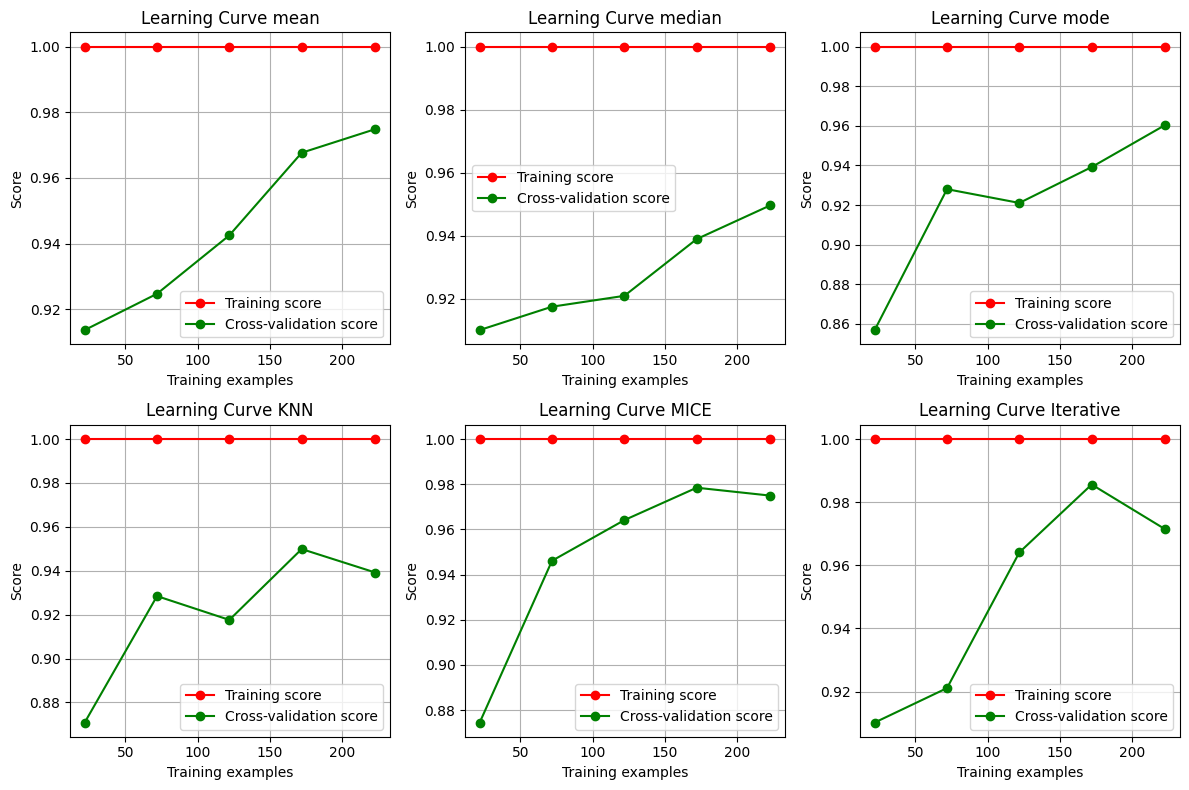

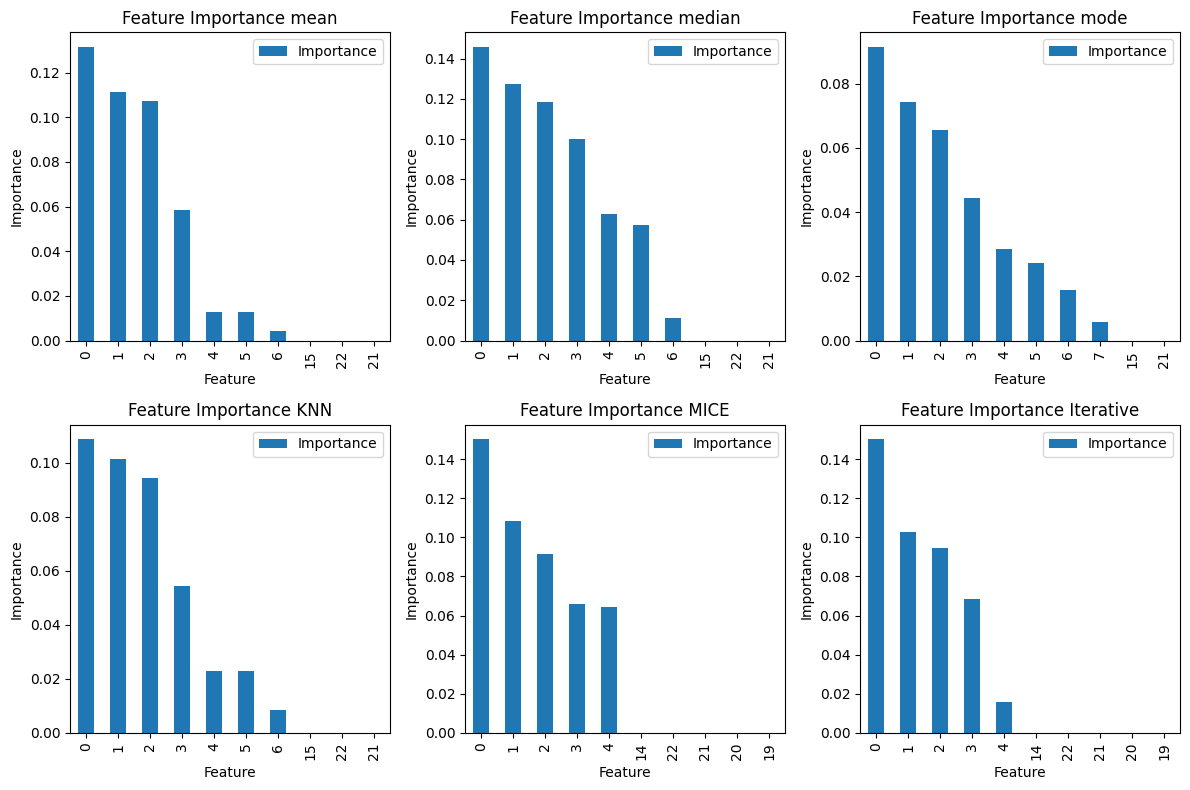

In [42]:
# Load the preprocessed data
dataframes = {}
for impute_name in imputation_methods.keys():
    dataframes[impute_name] = pd.read_csv(f'imputed/{impute_name}.csv')

# Initialize the model (for example, a decision tree classifier)
model = DecisionTreeClassifier()

# Train the model with your dataframes
models, metrics, confusion_matrices, learning_curves, feature_importances = train(DecisionTreeClassifier(), dataframes)


# Plot the learning curves
plot_learning_curves(learning_curves)

# Plot the feature importances
plot_feature_importances(feature_importances)

# 4. Train

In [43]:
all_train_losses = {}
all_val_losses = {}
all_train_accuracies = {}
all_val_accuracies = {}
epochsx = 5
# create a dictionary to store all the metrics
all_val_metrics = {
    'confusion_matrix': {},
    'classification_report': {}
}


for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df.copy()
    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])

    # Fill missing values in categorical columns with the most frequent category
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        df_imputed[cat_col].fillna(df_imputed[cat_col].mode()[0], inplace=True)

    # Preprocessing
    label_encoders = {}
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        label_encoders[cat_col] = LabelEncoder()
        df_imputed[cat_col] = label_encoders[cat_col].fit_transform(df_imputed[cat_col])

    scaler = StandardScaler()
    df_imputed[df_imputed.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df_imputed[df_imputed.select_dtypes(include=['float64']).columns])

    # Splitting the dataset
    train_df, temp_df = train_test_split(df_imputed, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    class CKDDataset(Dataset):
        def __init__(self, data):
            self.data = torch.tensor(data.drop(columns='class').values, dtype=torch.float32)
            self.targets = torch.tensor(data['class'].values, dtype=torch.long)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.targets[idx]

    train_dataset = CKDDataset(train_df)
    train_loader = DataLoader(train_dataset, batch_size=16)

    val_dataset = CKDDataset(val_df)
    val_loader = DataLoader(val_dataset, batch_size=16)

    test_dataset = CKDDataset(test_df)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Define the network architecture
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(24, 24)
            self.fc2 = nn.Linear(24, 2)
            self.dropout = nn.Dropout(0.2) # 20% dropout rate

        def forward(self, x):
            x = nn.functional.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Initialize the network and define the loss function and optimizer
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochsx):
        model.train()
        train_loss = 0.0
        correct = total = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total
        train_accuracies.append(train_acc)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = total_val = 0
        val_preds = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_preds.extend(predicted.tolist())
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()


        val_acc = correct_val / total_val
        val_loss /= len(val_loader)

        # Calculate confusion matrix and classification report
        cm = confusion_matrix(val_df['class'], np.array(val_preds))
        cr = classification_report(val_df['class'], np.array(val_preds), output_dict=True)

        all_val_metrics['confusion_matrix'][impute_name] = cm
        all_val_metrics['classification_report'][impute_name] = cr

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

        all_train_losses[impute_name] = train_losses
        all_val_losses[impute_name] = val_losses
        all_train_accuracies[impute_name] = train_accuracies
        all_val_accuracies[impute_name] = val_accuracies



Imputing with mean method
Epoch: 1, Train Loss: 0.640, Val Loss: 0.606, Train Acc: 0.693, Val Acc: 0.788
Epoch: 2, Train Loss: 0.548, Val Loss: 0.522, Train Acc: 0.857, Val Acc: 0.942
Epoch: 3, Train Loss: 0.467, Val Loss: 0.450, Train Acc: 0.898, Val Acc: 0.962
Epoch: 4, Train Loss: 0.395, Val Loss: 0.385, Train Acc: 0.939, Val Acc: 0.962
Epoch: 5, Train Loss: 0.330, Val Loss: 0.331, Train Acc: 0.967, Val Acc: 0.962
Imputing with median method
Epoch: 1, Train Loss: 0.545, Val Loss: 0.510, Train Acc: 0.717, Val Acc: 0.692
Epoch: 2, Train Loss: 0.456, Val Loss: 0.434, Train Acc: 0.717, Val Acc: 0.692
Epoch: 3, Train Loss: 0.384, Val Loss: 0.366, Train Acc: 0.783, Val Acc: 0.750
Epoch: 4, Train Loss: 0.327, Val Loss: 0.302, Train Acc: 0.889, Val Acc: 0.981


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 5, Train Loss: 0.276, Val Loss: 0.245, Train Acc: 0.963, Val Acc: 1.000
Imputing with mode method
Epoch: 1, Train Loss: 0.661, Val Loss: 0.607, Train Acc: 0.631, Val Acc: 0.692
Epoch: 2, Train Loss: 0.574, Val Loss: 0.525, Train Acc: 0.709, Val Acc: 0.692
Epoch: 3, Train Loss: 0.495, Val Loss: 0.455, Train Acc: 0.725, Val Acc: 0.692
Epoch: 4, Train Loss: 0.427, Val Loss: 0.393, Train Acc: 0.791, Val Acc: 0.885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 5, Train Loss: 0.368, Val Loss: 0.336, Train Acc: 0.926, Val Acc: 1.000
Imputing with KNN method
Epoch: 1, Train Loss: 0.663, Val Loss: 0.600, Train Acc: 0.598, Val Acc: 0.712
Epoch: 2, Train Loss: 0.540, Val Loss: 0.508, Train Acc: 0.836, Val Acc: 0.788
Epoch: 3, Train Loss: 0.452, Val Loss: 0.437, Train Acc: 0.857, Val Acc: 0.885
Epoch: 4, Train Loss: 0.384, Val Loss: 0.382, Train Acc: 0.939, Val Acc: 1.000
Epoch: 5, Train Loss: 0.336, Val Loss: 0.334, Train Acc: 0.947, Val Acc: 1.000
Imputing with MICE method
Epoch: 1, Train Loss: 0.634, Val Loss: 0.605, Train Acc: 0.623, Val Acc: 0.750
Epoch: 2, Train Loss: 0.545, Val Loss: 0.518, Train Acc: 0.840, Val Acc: 0.962
Epoch: 3, Train Loss: 0.462, Val Loss: 0.436, Train Acc: 0.947, Val Acc: 1.000
Epoch: 4, Train Loss: 0.382, Val Loss: 0.363, Train Acc: 0.955, Val Acc: 1.000
Epoch: 5, Train Loss: 0.316, Val Loss: 0.301, Train Acc: 0.967, Val Acc: 1.000
Imputing with Iterative method
Epoch: 1, Train Loss: 0.732, Val Loss: 0.652, Tra

# 3. Model Creation

# 5. Evaluation

# 6. Visualizing the performance

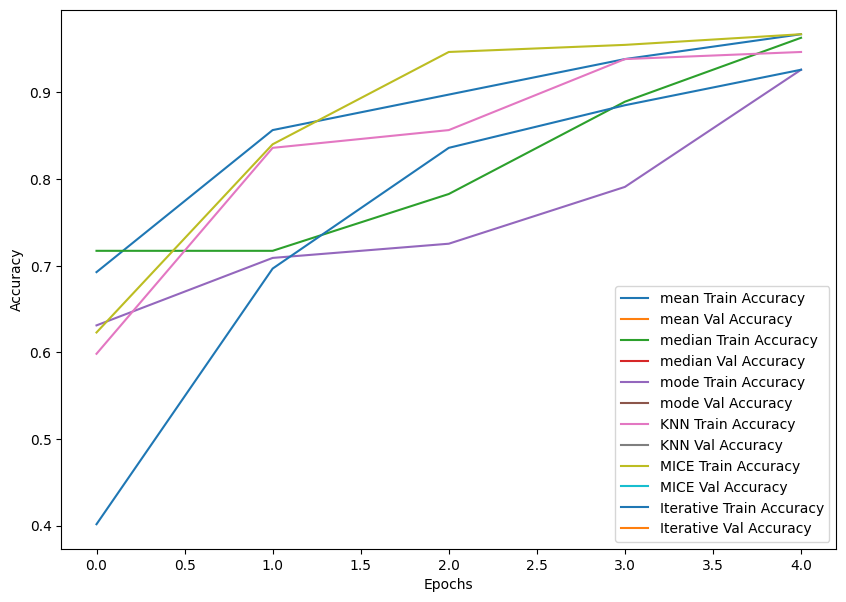

In [44]:
# Plotting train and validation accuracy
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_accuracies[impute_name], label=f'{impute_name} Train Accuracy')
        plt.plot(all_val_accuracies[impute_name], label=f'{impute_name} Val Accuracy')
    except KeyError:
        print(f"No data for {impute_name} in train/val accuracies")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

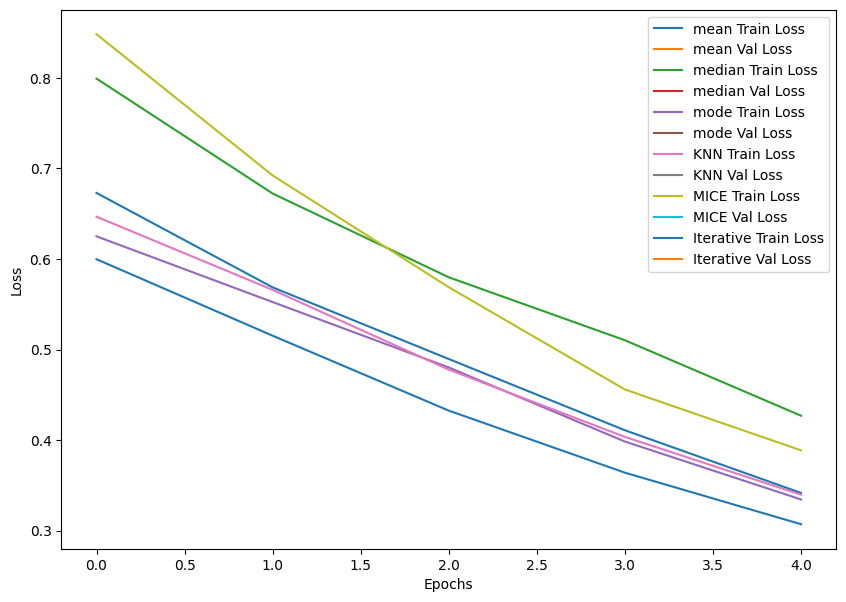

In [15]:
# Plotting train and validation loss
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_losses[impute_name], label=f'{impute_name} Train Loss')
        plt.plot(all_val_losses[impute_name], label=f'{impute_name} Val Loss')
    except KeyError:
        print(f"No data for {impute_name} in train/val losses")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. evaluate on the test set

In [16]:
# Print metrics
for impute_name in imputation_methods.keys():
    try:
        print(f'For {impute_name} imputation:')
        print('Confusion Matrix:')
        print(all_val_metrics['confusion_matrix'][impute_name])
        print('Classification Report:')
        print(all_val_metrics['classification_report'][impute_name])
        print()
    except KeyError:
        print(f"No data for {impute_name} in validation metrics")

For mean imputation:
Confusion Matrix:
[[34  2]
 [ 0 16]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.9444444444444444, 'f1-score': 0.9714285714285714, 'support': 36}, '1': {'precision': 0.8888888888888888, 'recall': 1.0, 'f1-score': 0.9411764705882353, 'support': 16}, 'accuracy': 0.9615384615384616, 'macro avg': {'precision': 0.9444444444444444, 'recall': 0.9722222222222222, 'f1-score': 0.9563025210084033, 'support': 52}, 'weighted avg': {'precision': 0.9658119658119658, 'recall': 0.9615384615384616, 'f1-score': 0.9621202327084679, 'support': 52}}

For median imputation:
Confusion Matrix:
[[34  2]
 [ 0 16]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.9444444444444444, 'f1-score': 0.9714285714285714, 'support': 36}, '1': {'precision': 0.8888888888888888, 'recall': 1.0, 'f1-score': 0.9411764705882353, 'support': 16}, 'accuracy': 0.9615384615384616, 'macro avg': {'precision': 0.9444444444444444, 'recall': 0.9722222222222222, 'f1-score': 0.9563025210084033,